In [9]:
import sys
import os
import time
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
from cil.recon import FBP
from cil.framework import AcquisitionGeometry, AcquisitionData, ImageGeometry, ImageData, BlockDataContainer
import h5py
from cil.processors import Slicer
from cil.plugins.astra import ProjectionOperator

In [2]:

with h5py.File("/dtu-compute/msaca/simulated_data/diffraction/single_powder_diffraction/integrated_data.h5", "r") as f:
    data_p = f["integrated"][:]


with h5py.File("/dtu-compute/msaca/simulated_data/diffraction/single_crystal_diffraction/integrated_data.h5", "r") as f:
    data_c = f["integrated"][:]

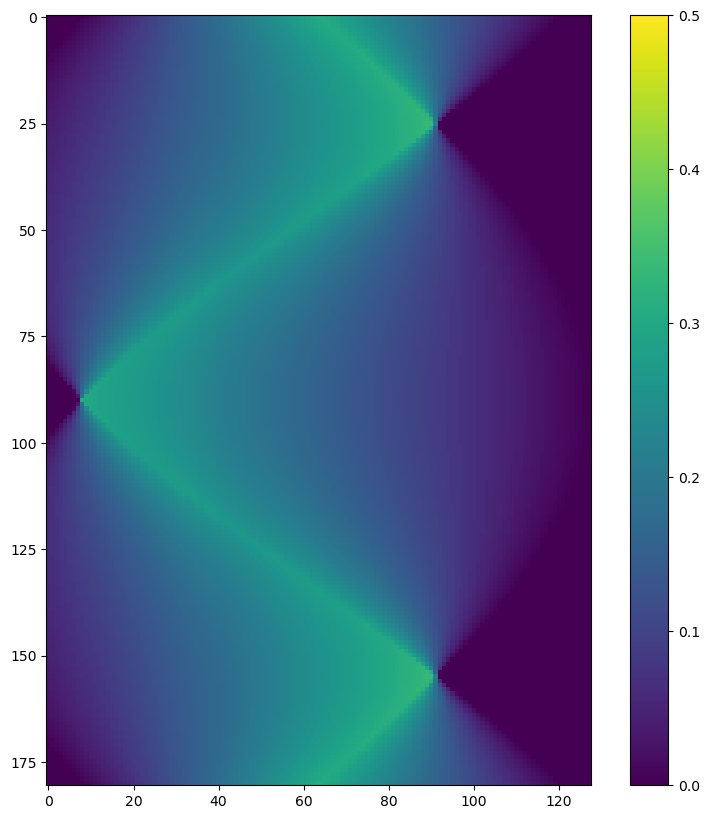

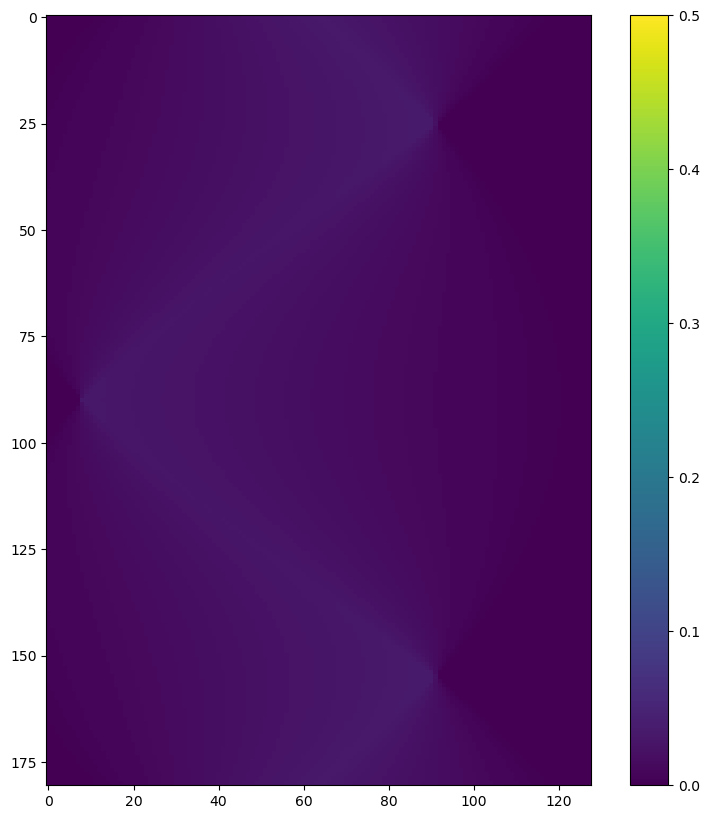

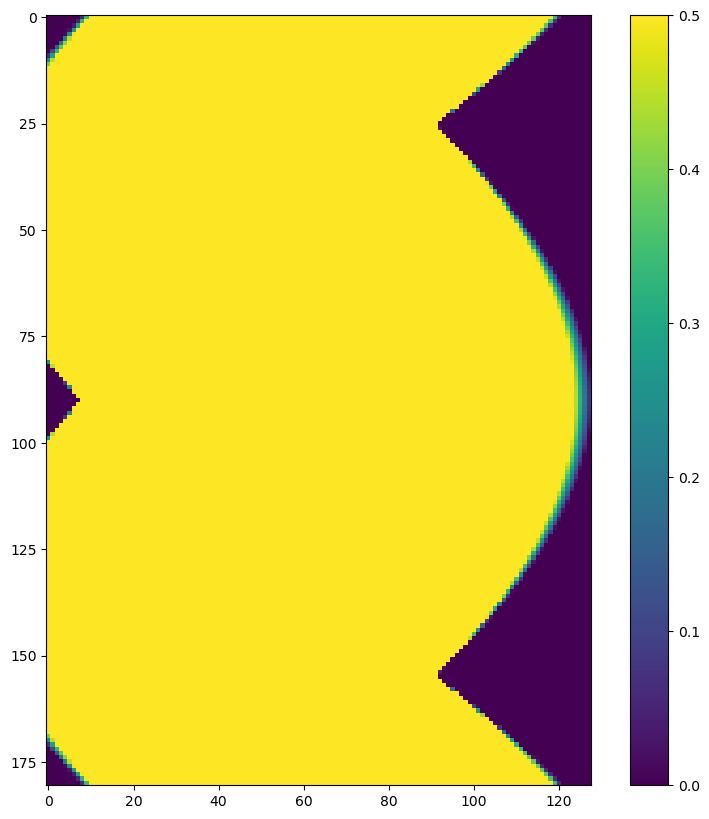

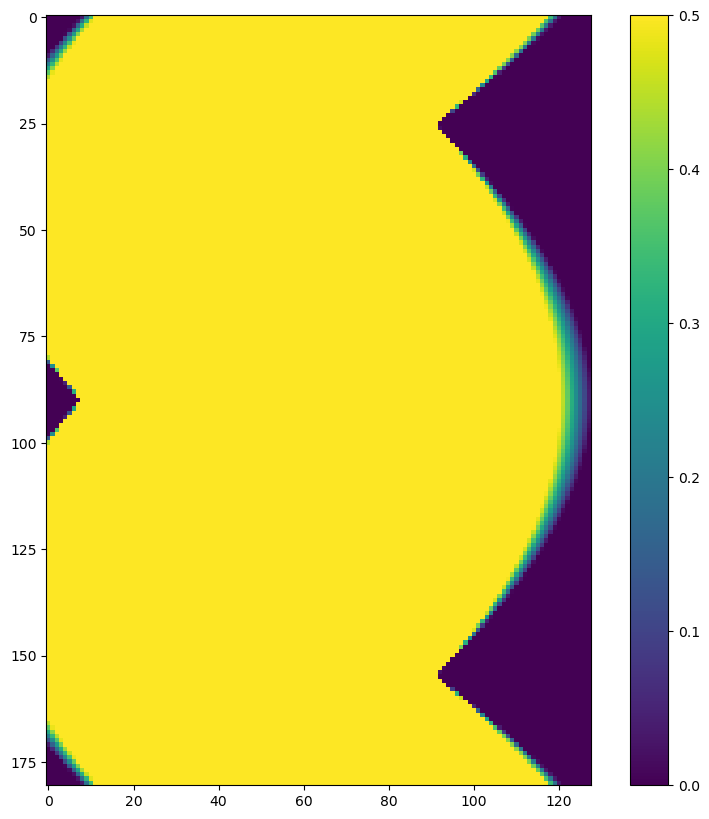

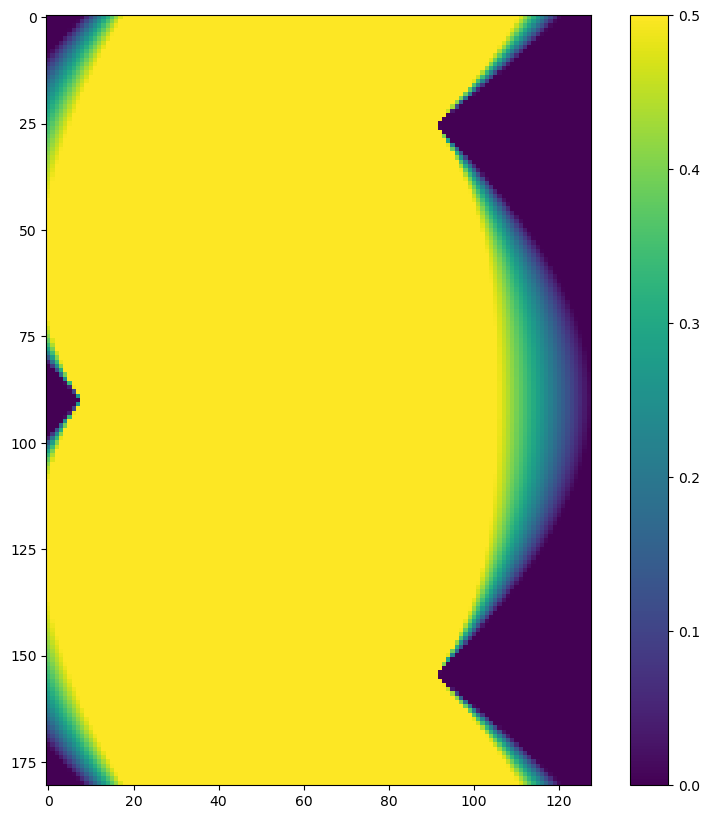

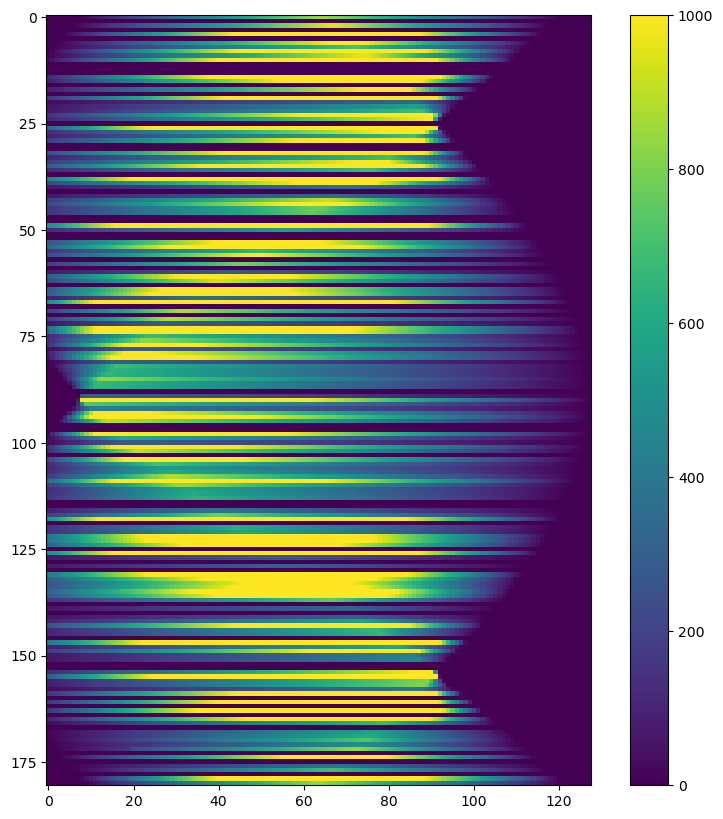

In [3]:

for i in range(5):

    plt.figure(figsize=(10,10))
    plt.imshow(data_p[:,:,60+45*(i)])
    plt.colorbar()
    plt.clim([0,0.5])
    plt.show()



plt.figure(figsize=(10,10))
plt.imshow(np.sum(data_c[:,:,:],axis=2))
plt.colorbar()
plt.clim([0,1000])
plt.show()

In [4]:

def zero_pad_3d(array: np.ndarray, N: int, values: np.ndarray) -> np.ndarray:
    """
    Pads a 3D NumPy array along the last two dimensions by N pixels.
    Each slice along axis=0 is padded with a different value.

    Parameters:
    array (np.ndarray): Input 3D array of shape (D, H, W).
    N (int): Number of pixels to pad along the last two dimensions.
    values (np.ndarray): 1D array of length D, specifying the padding value for each slice.

    Returns:
    np.ndarray: Padded 3D array of shape (D, H+2N, W+2N).
    """
    if N < 0:
        raise ValueError("Padding size N must be non-negative")
    
    if values.shape[0] != array.shape[0]:
        raise ValueError("Length of values array must match the first dimension of array")

    D, H, W = array.shape
    padded_shape = (D, H, W + 2 * N)
    padded_array = np.empty(padded_shape, dtype=array.dtype) 

    # Apply different padding values per slice
    for i in range(D):
        padded_array[i] = np.pad(
            array[i], 
            ((0, 0), (N, N)), 
            mode='edge', 
            #constant_values=values[i]
        )

    return padded_array

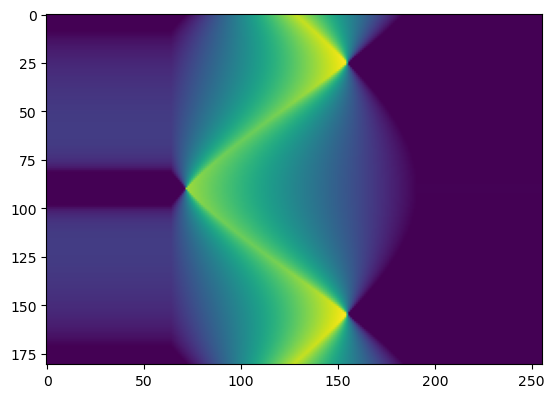

FBP recon

Input Data:
	angle: 181
	vertical: 256
	horizontal: 256

Reconstruction Volume:
	vertical: 256
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



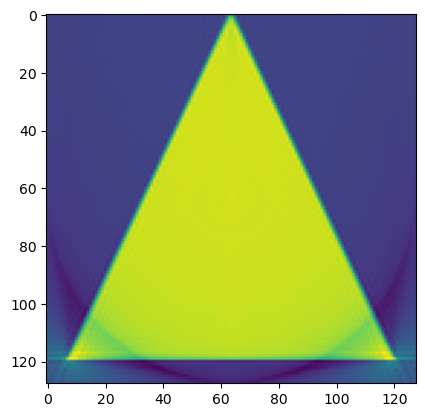

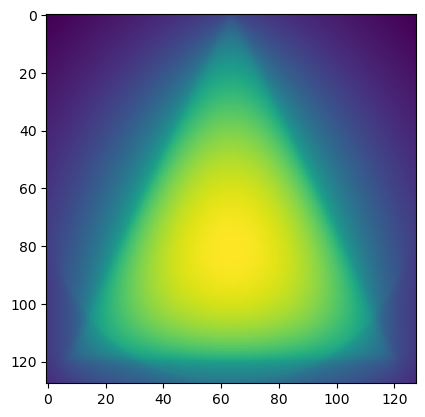

In [20]:
data = np.transpose(data_p,[2,0,1])[:]
pad = 64
recon = []

data_= zero_pad_3d(data, pad,values=np.mean(data[:,:,-10:],axis=(1,2)))
N = 128
plt.imshow(data_[N])
plt.show()
nchannels,ntheta, nx = np.shape(data)
nchannels,ntheta, nx_ = np.shape(data_)
recon_nolog = np.zeros((nchannels, nx, nx))
angles = range(0,ntheta)

ag = AcquisitionGeometry.create_Parallel3D(detector_position=[0,nx_//2,0])\
                        .set_angles(angles)\
                        .set_panel((nx_, nchannels), pixel_size=(1,1))\
                        .set_labels(['vertical','angle', 'horizontal'])
data_ = AcquisitionData(data_, geometry=ag)
data_.reorder('astra')
ig_ = ag.get_ImageGeometry()
roi = {'horizontal_x':(pad,-pad,1), 'horizontal_y':(pad,-pad,1)}
processor = Slicer(roi)
processor.set_input(ig_)
ig = processor.get_output()
device = 'gpu'


data_cil = AcquisitionData(data_, geometry=ag)
data_cil.reorder('tigre')
fbp = FBP(data_cil, image_geometry=ig)
out = fbp.run()

recon.append(out.as_array())
plt.imshow(recon[0][N])
plt.show()



back_projs = []
ag2d = AcquisitionGeometry.create_Parallel2D(detector_position=[0,nx//2])\
                    .set_angles(angles)\
                    .set_panel((nx), pixel_size=(1))\
                    .set_labels(['angle', 'horizontal'])
ig2d_ = ag2d.get_ImageGeometry()
roi = {'horizontal_y':(0,nx,1)}
processor = Slicer(roi)
processor.set_input(ig2d_)
ig2d = processor.get_output()
P0 = ProjectionOperator(ig2d, ag2d)

data_ = AcquisitionData(data[N], geometry=ag2d)
data_.reorder('astra')
im_back_proj = P0.adjoint(data_)

back_projs.append(im_back_proj.as_array())
plt.imshow(back_projs[0])